In [2]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

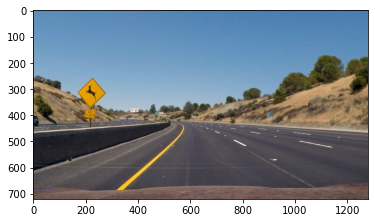

In [3]:
test_img =  mpimg.imread("test2.jpg") 
im = mpimg.imread("test2.jpg") 
plt.imshow(im)

In [4]:
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

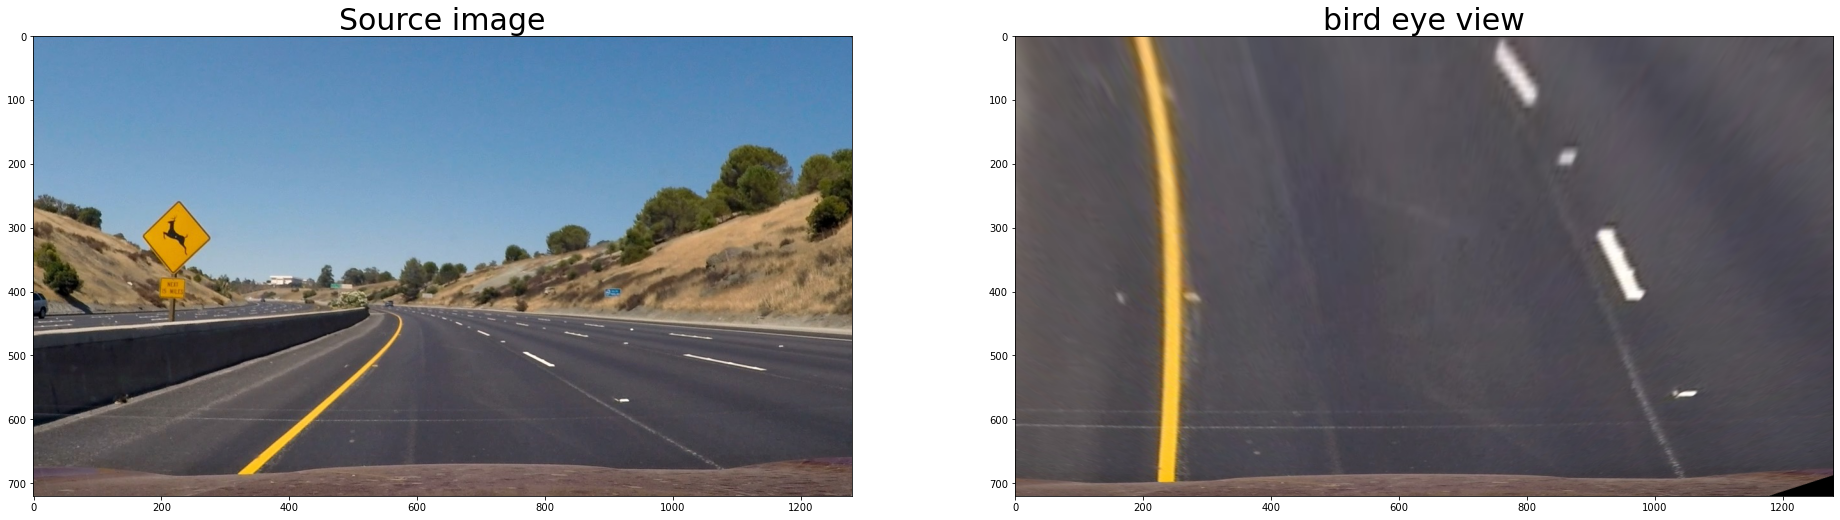

In [5]:
import cv2
import numpy as np

src = np.float32([(550, 460),     # top-left
                               (150, 720),     # bottom-left
                               (1200, 720),    # bottom-right
                               (770, 460)])    # top-right
dst = np.float32([(100, 0),
                               (100, 720),
                               (1100, 720),
                               (1100, 0)])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
        
forward_image= cv2.warpPerspective(test_img, M, (1280, 720), flags=cv2.INTER_LINEAR)  
backward_image = cv2.warpPerspective(test_img, M_inv, (1280, 720), flags=cv2.INTER_LINEAR)
#prespective_forward(np.array(test_img),img_size= (1280,720),flags=cv2.INTER_LINEAR)        
plt_images(test_img, 'Source image',forward_image, 'bird eye view')

# Thresholding


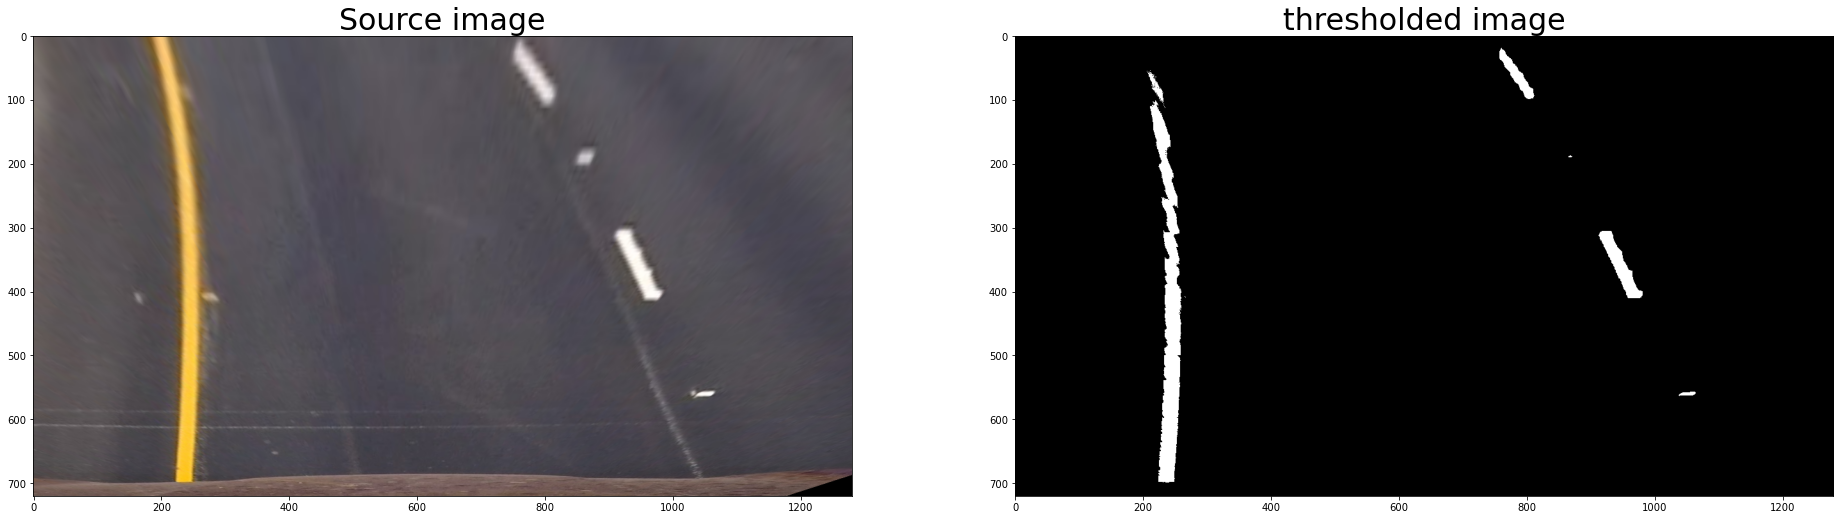

In [6]:
import cv2
import numpy as np

def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255



def threshold_forward(img):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        v_channel = hsv[:,:,2]

        right_lane = threshold_rel(l_channel, 0.8, 1.0)
        right_lane[:,:750] = 0

        left_lane = threshold_abs(h_channel, 20, 30)
        left_lane &= threshold_rel(v_channel, 0.7, 1.0)
        left_lane[:,550:] = 0

        img2 = left_lane | right_lane

        return img2
thresholded_image = threshold_forward(forward_image)
plt_images(forward_image, 'Source image',thresholded_image, 'thresholded image')

# Lane Line Detection

In [8]:
left_fit = None
right_fit = None
binary = None
nonzero = None
nonzerox = None
nonzeroy = None
clear_visibility = True
dir = []
left_curve_img = mpimg.imread('left_turn.png')
right_curve_img = mpimg.imread('right_turn.png')
keep_straight_img = mpimg.imread('straight.png')
left_curve_img = cv2.normalize(src=left_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
right_curve_img = cv2.normalize(src=right_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
keep_straight_img = cv2.normalize(src=keep_straight_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# HYPERPARAMETERS

# Number of sliding windows
nwindows = 9
# Width of the the windows +/- margin ,, width = 200
margin = 100
# Mininum number of pixels found to recenter window
minpix = 50

window_height=None
left_fit=None
right_fit=None


In [9]:
def extract_features(img):
    """ Extract features from a binary image

    Parameters:
        img (np.array): A binary image
    """
    img = img
    # Height of of windows - based on nwindows and image shape
    global window_height
    window_height = np.int(img.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixel in the image
    global nonzero
    nonzero = img.nonzero()
    global nonzerox
    nonzerox = np.array(nonzero[1])
    global nonzeroy
    nonzeroy = np.array(nonzero[0])

In [1]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

In [2]:
##3 betkhaly el image 3 channels + bt return all pixels that belong to the lane
def find_lane_pixels(img):
    """Find lane pixels from a binary warped image.

    Parameters:
        img (np.array): A binary warped image

    Returns:
        leftx (np.array): x coordinates of left lane pixels
        lefty (np.array): y coordinates of left lane pixels
        rightx (np.array): x coordinates of right lane pixels
        righty (np.array): y coordinates of right lane pixels
        out_img (np.array): A RGB image that use to display result later on.
    """
    assert(len(img.shape) == 2)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))

    ## returns array of (x,sum of nonzero pixels)
    histogram = hist(img)
    midpoint = histogram.shape[0]//2
    ## x positions of max sum of left and right side of histogram
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Current position to be update later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    ## img shape[0] is the rows == y axis (vertical) bel tool 3shan ba3d keda yena2s menha fa yewsal le center eli 3aleha el door.
    y_current = img.shape[0] + window_height//2

    # Create empty lists to reveice left and right lane pixel
    leftx, lefty, rightx, righty = [], [], [], []

    # Step through the windows one by one
    ##  _ 3shan man3mlsh variable manstakhdmosh 3shan ehna nas professional
    for _ in range(nwindows):
        y_current -= window_height
        center_left = (leftx_current, y_current)
        center_right = (rightx_current, y_current)

        good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height)
        good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height)

        # Append these indices to the lists
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)
        rightx.extend(good_right_x)
        righty.extend(good_right_y)

        ## recenter the window update x value 
        if len(good_left_x) > minpix:
            leftx_current = np.int32(np.mean(good_left_x))
        if len(good_right_x) > minpix:
            rightx_current = np.int32(np.mean(good_right_x))

    return leftx, lefty, rightx, righty, out_img

In [10]:
##4 be7aded el two lines wel area el benhom betlwenha akhdar
def fit_poly(img):
    global left_fit
    global right_fit
    

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)


    ## polyfit(x,y,degree)
    if len(lefty) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting

    #akher el sora
    maxy = img.shape[0] - 1

    #lehad akher el taree2 ta2reban
    miny = img.shape[0] // 3


    #nezabat el min yeb2a min el no2at eli 3l taree2
    if len(lefty):
        
        miny = min(miny, np.min(lefty))

    if len(righty):
      
        miny = min(miny, np.min(righty))


    ## get x values to substitute in the poly fn.
    ploty = np.linspace(miny, maxy, img.shape[0])


    ##  x =  ay^2 + by+ c
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ## byrsem el area el been el lanes bl akhdar
    # Visualization
    for i, y in enumerate(ploty):
        l = int(left_fitx[i])
        r = int(right_fitx[i])
        y = int(y)
        cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

  
  
    return out_img

In [11]:
def lane_line_forward(img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        ##bamla el nonzero matrix
        extract_features(img)
        
        ##return el area el khadra
        return fit_poly(img)

In [3]:
def pixels_in_window(center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)
        #check if the pixel is in the given window
        condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
        condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
        #return these pixels
        return nonzerox[condx&condy], nonzeroy[condx&condy]